In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from nltk.corpus import stopwords
import string
import re
from nrclex import NRCLex
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def preprocess_text(text):
    STOPWORDS = set(stopwords.words('english'))

    text = text.lower()
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])
    PUNCT_TO_REMOVE = string.punctuation
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

    characters_to_remove = '“”'
    for char in characters_to_remove:
        text = text.replace(char, '')

    pattern = r'\d+'
    text = re.sub(pattern, '', text)

    pattern = r'\b\w\b'
    text = re.sub(pattern, '', text)

    pattern = r'^\s*|\s\s*'
    text = re.sub(pattern, ' ', text).strip()

    return text

In [4]:
def get_emotion(text):
    emotion = NRCLex(text)
    return emotion.affect_frequencies

In [5]:
sessions = np.arange(25, 76)
data=[]

for session in sessions:
    directory = "./TXT/Session "+str(session)+" - "+str(1945+session)
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename)) as f:
            if filename[0]==".": #ignore hidden files
                continue
            splt = filename.split("_")
            data.append([session, 1945+session, splt[0], f.read()]) 

df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])
df_codes = pd.read_csv('UNSD — Methodology.csv', delimiter=';')

# Merge data with regions and such
df = pd.merge(left=df_speech, right=df_codes, how='inner', on='ISO-alpha3 Code')
df = df[["Country or Area", "Region Name","Sub-region Name", "ISO-alpha3 Code","Least Developed Countries (LDC)", "Session", "Year", "Speech"]]
df['Country or Area'] = df['Country or Area'].str.strip()
un_df = df.set_index(['ISO-alpha3 Code'])


##### The data for the UN debates !!
un_df.head()
un_df.shape

,Country or Area,Region Name,Sub-region Name,Least Developed Countries (LDC),Session,Year,Speech
ISO-alpha3 Code,,,,,,,
AUT,Austria,Europe,Western Europe,NaN,25,1970,155.\t May I begin by expressing to Ambassado...
AUT,Austria,Europe,Western Europe,NaN,26,1971,112.\t Mr. President. I am happy to convey to...
AUT,Austria,Europe,Western Europe,NaN,27,1972,"Mr. President, I take the greatest pleasure in..."
AUT,Austria,Europe,Western Europe,NaN,28,1973,﻿1.\tThe twenty-eighth session of the General ...
AUT,Austria,Europe,Western Europe,NaN,29,1974,"Sir, it is more than a mere custom, and for me..."


(8385, 7)

In [6]:
### The data for the happiness
happy_df = pd.read_excel('DataForTable2.1WHR2023.xls') 
happy_df = happy_df.rename(columns={'Country name': 'Country or Area'})
happy_df = happy_df.rename(columns={'year': 'Year'})
happy_df['Country or Area'] = happy_df['Country or Area'].str.strip()

df = pd.merge(left=un_df, right=happy_df , how='inner', on=["Country or Area", "Year"])

df.head(3)
df.shape

,Country or Area,Region Name,Sub-region Name,Least Developed Countries (LDC),Session,Year,Speech,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Austria,Europe,Western Europe,NaN,61,2006,“United in diversity”: \nthis motto of the Eur...,7.122211,10.836452,0.936350,69.500000,0.941382,0.298436,0.490111,0.746153,0.173812
1,Austria,Europe,Western Europe,NaN,63,2008,"These days, on our \ntelevision screens, image...",7.180954,10.881175,0.934593,69.699997,0.879069,0.287321,0.613625,0.716296,0.173195
2,Austria,Europe,Western Europe,NaN,65,2010,"The tragic \nearthquake in Haiti, the devastat...",7.302679,10.855984,0.914193,69.900002,0.895980,0.126924,0.546145,0.710302,0.155793


(1683, 16)

In [7]:
#### Import and Export trades data

df_trade = pd.read_csv('National_COW_4.0.csv') 
df_trade = df_trade.rename(columns={'statename': 'Country or Area'})
df_trade = df_trade.rename(columns={'year': 'Year'})
data = pd.merge(left=df, right=df_trade , how='inner', on=["Country or Area","Year"])
data.head(3)
data.shape

,Country or Area,Region Name,Sub-region Name,Least Developed Countries (LDC),Session,Year,Speech,Life Ladder,Log GDP per capita,Social support,...,Negative affect,ccode,stateabb,imports,exports,alt_imports,alt_exports,source1,source2,version
0,Austria,Europe,Western Europe,NaN,61,2006,“United in diversity”: \nthis motto of the Eur...,7.122211,10.836452,0.936350,...,0.173812,305,AUS,137319.9553,136865.7334,NaN,NaN,2.0,2.0,4
1,Austria,Europe,Western Europe,NaN,63,2008,"These days, on our \ntelevision screens, image...",7.180954,10.881175,0.934593,...,0.173195,305,AUS,184500.5344,181736.4085,NaN,NaN,2.0,2.0,4
2,Austria,Europe,Western Europe,NaN,65,2010,"The tragic \nearthquake in Haiti, the devastat...",7.302679,10.855984,0.914193,...,0.155793,305,AUS,157436.8100,148635.1050,NaN,NaN,2.0,2.0,4


(932, 25)

In [8]:
# Adding emotions to speech
data["Speech"] = data["Speech"].apply(lambda text: preprocess_text(text))
data['Emotions'] = data['Speech'].apply(get_emotion)
data['Emotions'] = data['Emotions'].apply(lambda x: {k: v for k, v in x.items() if k not in ['positive', 'negative','trust']})
emotions_df=data['Emotions'].apply(pd.Series)
df = pd.concat([data.drop('Emotions', axis=1), emotions_df], axis=1)
df.head()
df.shape

,Country or Area,Region Name,Sub-region Name,Least Developed Countries (LDC),Session,Year,Speech,Life Ladder,Log GDP per capita,Social support,...,source2,version,fear,anger,anticip,surprise,sadness,disgust,joy,anticipation
0,Austria,Europe,Western Europe,NaN,61,2006,united diversity motto european union expresse...,7.122211,10.836452,0.936350,...,2.0,4,0.074656,0.058939,0.0,0.027505,0.051081,0.029470,0.066798,0.082515
1,Austria,Europe,Western Europe,NaN,63,2008,days television screens images thousands paren...,7.180954,10.881175,0.934593,...,2.0,4,0.072848,0.046358,0.0,0.029801,0.021523,0.013245,0.094371,0.119205
2,Austria,Europe,Western Europe,NaN,65,2010,tragic earthquake haiti devastating floods pak...,7.302679,10.855984,0.914193,...,2.0,4,0.061198,0.046875,0.0,0.026042,0.027344,0.016927,0.072917,0.118490
3,Austria,Europe,Western Europe,NaN,66,2011,year confirmed importance united nations truly...,7.470513,10.881422,0.944157,...,2.0,4,0.065041,0.040650,0.0,0.032520,0.026423,0.020325,0.081301,0.119919
4,Austria,Europe,Western Europe,NaN,67,2012,events recent months illustrated importanceof ...,7.400689,10.883644,0.945142,...,2.0,4,0.076493,0.048507,0.0,0.039179,0.042910,0.027985,0.091418,0.106343


(932, 33)

In [9]:
grouped_year = df.groupby('Year')['Life Ladder'].median().reset_index()
df = pd.merge(left=grouped_year, right=df, how='inner', on=["Year"], suffixes=('_median',''))


df['Happiness_target'] = np.where(
    (df['Life Ladder'].notna()) & (df['Life Ladder_median'].notna()),
    np.where(df['Life Ladder'] > df['Life Ladder_median'], 'happy', 'not-happy'),
    np.where(df['Life Ladder'].isna(), 'null-value-in-Life-Ladder', 'null-value-in-Life-Ladder-median')
)
df.head()
df.shape

,Year,Life Ladder_median,Country or Area,Region Name,Sub-region Name,Least Developed Countries (LDC),Session,Speech,Life Ladder,Log GDP per capita,...,version,fear,anger,anticip,surprise,sadness,disgust,joy,anticipation,Happiness_target
0,2005,6.600104,Mexico,Americas,Latin America and the Caribbean,NaN,60,past year we member states embarked upon refor...,6.580658,9.791636,...,4,0.044010,0.029340,0.0,0.034230,0.031785,0.026895,0.056235,0.100244,not-happy
1,2005,6.600104,Japan,Asia,Eastern Asia,NaN,60,like first foremost convey again sincere sympa...,6.515817,10.551915,...,4,0.060606,0.028520,0.0,0.033868,0.035651,0.024955,0.057041,0.112299,not-happy
2,2005,6.600104,Belgium,Europe,Western Europe,NaN,60,allow congratulate warmly sir election preside...,7.262290,10.743808,...,4,0.072381,0.049524,0.0,0.040000,0.038095,0.034286,0.097143,0.091429,happy
3,2005,6.600104,Pakistan,Asia,Southern Asia,NaN,60,let congratulate president current session for...,5.224658,8.252209,...,4,0.059840,0.043883,0.0,0.019947,0.041223,0.031915,0.070479,0.093085,not-happy
4,2005,6.600104,France,Europe,Western Europe,NaN,60,speaking first time rostrum wish reaffirm impo...,7.093393,10.636769,...,4,0.070225,0.043539,0.0,0.036517,0.036517,0.028090,0.081461,0.102528,happy


(932, 35)

In [10]:
# make standardized column names
df = df.rename(columns={'Year': 'year', 
                   'Life Ladder_median': 'life_ladder_year_median', 
                   'Country or Area': 'country',
                   'Region Name': 'region',
                   'Sub-region Name': "subregion",
                   'Least Developed Countries (LDC)': 'least_developed_countries',
                   'Session': 'session',
                   'Speech': 'speech',
                   'Life Ladder': 'life_ladder',
                   'Log GDP per capita': 'log_gdp_per_capita',
                   'Social support': 'social_support',
                   'Healthy life expectancy at birth': 'healthy_life_expectancy',
                   'Freedom to make life choices': 'choice_freedom',
                   'Generosity': 'generosity',
                   'Perceptions of corruption': 'corruption_perception',
                   'Positive affect': 'positive_affect',
                   'Negative affect': 'negative_affect',
                   'Happiness_target': 'happiness_classification'})

# binary preprocess fix
df['least_developed_countries'] = df.least_developed_countries.fillna('no')
df['least_developed_countries'] = df.least_developed_countries.replace('x', 'yes')

df['gdp_per_capita'] = np.exp(df['log_gdp_per_capita'])

In [11]:
df['gdp_per_capita'].head()

0    17883.531015
1    38250.624609
2    46342.177785
3     3836.089279
4    41638.033473
Name: gdp_per_capita, dtype: float64

Note that `gdp_per_capita` was given in US dollars and `imports` and `exports` in millions of US dollars.

In [12]:
df['norm_imports'] = df['imports'] / df['gdp_per_capita']
df['norm_exports'] = df['exports'] / df['gdp_per_capita']

In [13]:
filtered_df = df.loc[:,['happiness_classification', 'norm_imports', 'norm_exports', \
                 'fear', 'anger', 'surprise', 'sadness', 'disgust', 'joy', 'anticipation', \
                    'year', 'country']]

filtered_df.head()

,happiness_classification,norm_imports,norm_exports,fear,anger,surprise,sadness,disgust,joy,anticipation,year,country
0,not-happy,13.643921,11.979343,0.044010,0.029340,0.034230,0.031785,0.026895,0.056235,0.100244,2005,Mexico
1,not-happy,13.469564,15.552570,0.060606,0.028520,0.033868,0.035651,0.024955,0.057041,0.112299,2005,Japan
2,happy,6.874739,7.213294,0.072381,0.049524,0.040000,0.038095,0.034286,0.097143,0.091429,2005,Belgium
3,not-happy,6.624081,4.183923,0.059840,0.043883,0.019947,0.041223,0.031915,0.070479,0.093085,2005,Pakistan
4,happy,12.099429,11.116681,0.070225,0.043539,0.036517,0.036517,0.028090,0.081461,0.102528,2005,France


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Missing Values (purple)')

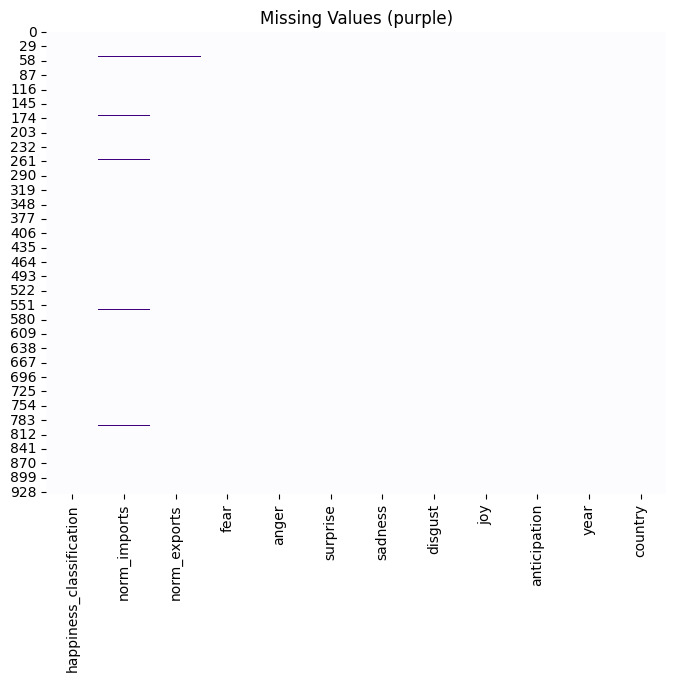

In [14]:
# Create a Boolean DataFrame where missing values are True
missing_values = filtered_df.isnull()

# Create a heatmap of missing values
plt.figure(figsize=(8, 6))
sns.heatmap(missing_values, cbar=False, cmap='Purples')
plt.title('Missing Values (purple)')
plt.show()

In [15]:
# Decided that the null values are fairly evenly distributed so we can drop them all. 
print(filtered_df.shape)
filtered_df = filtered_df.dropna()
print(filtered_df.shape)

(932, 12)
(921, 12)


In [16]:
filtered_df.to_csv('Data/preprocessed_dataset.csv', index=False)

filtered_df.head()
filtered_df.shape

,happiness_classification,norm_imports,norm_exports,fear,anger,surprise,sadness,disgust,joy,anticipation,year,country
0,not-happy,13.643921,11.979343,0.044010,0.029340,0.034230,0.031785,0.026895,0.056235,0.100244,2005,Mexico
1,not-happy,13.469564,15.552570,0.060606,0.028520,0.033868,0.035651,0.024955,0.057041,0.112299,2005,Japan
2,happy,6.874739,7.213294,0.072381,0.049524,0.040000,0.038095,0.034286,0.097143,0.091429,2005,Belgium
3,not-happy,6.624081,4.183923,0.059840,0.043883,0.019947,0.041223,0.031915,0.070479,0.093085,2005,Pakistan
4,happy,12.099429,11.116681,0.070225,0.043539,0.036517,0.036517,0.028090,0.081461,0.102528,2005,France


(921, 12)